In [ ]:
#we want to check how the number of edges behaves with decrease of the population size
#compute the average of 10 subsamples for every parameter value

In [16]:
import numpy as np
import time
import json
import os
from ancinf.utils.simulate import collectparams, collectdatasetparams, labeldict_to_labellist
from ancinf.utils.ibdloader import load_pure, translate_indices
from ancinf.utils.baseheuristic import gettrainvaltestnodes, composegraphs, getrandompermutation, dividetrainvaltest, checkpartition

rng = np.random.default_rng(2023)
datadir = "/home/dglyzin/identityByDescent/datasets-pure"
workdir = "/home/dglyzin/identityByDescent/datasets-tmp"
factors = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
prjfile = "nosim.ancinf"



In [2]:
params = collectparams(datadir, workdir, prjfile)
print(params)

processing dataset Scandinavia_weights_partial_labels
Partition is ok, no dangling nodes found
processing dataset Volga_weights_partial_labels
Partition is ok, no dangling nodes found
processing dataset NC_graph_rel
Partition is ok, no dangling nodes found
processing dataset Western-Europe_weights_partial_labels
Partition is ok, no dangling nodes found


In [17]:
with open(os.path.join(workdir, prjfile),"r") as f:
    meta = json.load(f)

tempname = "tmpds.csv"

results = {}

for dataset in meta['datasets']:
    print(dataset)
    filters = meta['datasets'][dataset]["filters"]
    print(filters)
    fnamepath = os.path.join(datadir, dataset+'.csv')
    pairs, weights, labels, labeldict, idxtranslator = load_pure( fnamepath, debug=False, **filters )
    conseq_pairs = translate_indices(pairs, idxtranslator)
    labellist = labeldict_to_labellist(labeldict)
    graphdata = composegraphs(pairs, weights, labels, labeldict, idxtranslator)
    ncls = graphdata[0]['nodeclasses']
    grph = graphdata[0]['graph']
    trns = graphdata[0]['translation']
            
    results[dataset] = []
    for factor in factors:
        #create reduced populations
        permt = getrandompermutation(ncls, rng)
        valshare = 1.0-factor
        testshare = 0.0
        trainnodeclasses, valnodeclasses, testnodeclasses = dividetrainvaltest(ncls, valshare, testshare, permt)        
        part_ok, part_errors = checkpartition(grph, trainnodeclasses, valnodeclasses, testnodeclasses, details=False, trns=trns)
        if not part_ok:
            print("bad partition on iter", itr)
        trainnodes, _, _ = gettrainvaltestnodes(trainnodeclasses, valnodeclasses, testnodeclasses)
        #traindf, valdf, testdf = translateconseqtodf(trns, trainnodeclasses, valnodeclasses, testnodeclasses)
        
        #save them
        with open(tempname, 'w', encoding="utf-8") as f:
            f.write('node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n\n')
            for idx in range(pairs.shape[0]):
                i = conseq_pairs[idx][0]
                j = conseq_pairs[idx][1]
                if (i in trainnodes) and (j in trainnodes):
                    label_i = labellist[labels[i]]
                    label_j = labellist[labels[j]]
                    name_i = label_i if "," not in label_i else '\"' + label_i + '\"'
                    name_j = label_j if "," not in label_j else '\"' + label_j + '\"'
                    f.write(f'node_{pairs[idx][0]},node_{pairs[idx][1]},{name_i},{name_j},{weights[idx][0]},{pairs[idx][2]}\n')
        params = collectdatasetparams(tempname)
        
        
        results[dataset].append(params)
    

Scandinavia_weights_partial_labels
{'only': [], 'minclassize': 190, 'removeclasses': ['Russians', 'Tatars,Volga-Tatars,Mishar-Tatars,Kryashens', 'English', 'Finns']}
Partition is ok, no dangling nodes found
Partition is ok, no dangling nodes found
Partition is ok, no dangling nodes found
Partition is ok, no dangling nodes found
Partition is ok, no dangling nodes found
Partition is ok, no dangling nodes found
Partition is ok, no dangling nodes found
Partition is ok, no dangling nodes found
Partition is ok, no dangling nodes found
Partition is ok, no dangling nodes found
Volga_weights_partial_labels
{'only': [], 'minclassize': 49, 'removeclasses': ['Finns', 'Poles', 'English', 'Karelians,Veps', 'Norwegians', 'Mordvins', 'Dolgans,Yakuts', 'Kazakhs', 'Ashkenazim', 'Belarusians', 'Swedes', 'Ukrainians', 'Germans', 'Lithuanians', 'Bashkirs', 'Russians']}
Partition is ok, no dangling nodes found
Partition is ok, no dangling nodes found
Partition is ok, no dangling nodes found
Partition is ok,

In [26]:
#for ds in results:
#    print(ds, ":")
#    print(results[ds])    

lines=[]
for ds in results:
    labels = results[ds][0]["pop_names"]
    labelcount = len(labels)
    print (labels)
    for idx, label in enumerate(labels):
        print(idx)
        line = {"pop_sizes":[], "edge_probability":[], "label": label}
        for ds_iter in results[ds]:
            if len(ds_iter["pop_sizes"])==labelcount:
                line["pop_sizes"].append(ds_iter["pop_sizes"][idx]) 
                line["edge_probability"].append(ds_iter["edge_probability"][idx][idx])
            else:
                print("bad iteration, skip", ds_iter["pop_sizes"])
           
        lines.append(line)
print(lines)

['Swedes', 'Norwegians', 'Danes']
0
1
2
['Udmurts,Besermyan', 'Tatars,Volga-Tatars,Mishar-Tatars,Kryashens', 'Chuvash', 'Mari']
0
1
2
3
['чеченцы', 'кабардинцы,черкесы,адыгейцы', 'карачаевцы,балкарцы', 'дагестанские народы', 'ингуши', 'кумыки', 'ногайцы', 'осетины']
0
bad iteration, skip [9, 7, 9, 7, 5, 4, 1]
1
bad iteration, skip [9, 7, 9, 7, 5, 4, 1]
2
bad iteration, skip [9, 7, 9, 7, 5, 4, 1]
3
bad iteration, skip [9, 7, 9, 7, 5, 4, 1]
4
bad iteration, skip [9, 7, 9, 7, 5, 4, 1]
5
bad iteration, skip [9, 7, 9, 7, 5, 4, 1]
6
bad iteration, skip [9, 7, 9, 7, 5, 4, 1]
7
bad iteration, skip [9, 7, 9, 7, 5, 4, 1]
['English', 'Germans', 'French', 'Belgium']
0
1
2
3
[{'pop_sizes': [377, 339, 302, 264, 226, 188, 149, 112, 68, 32], 'edge_probability': [0.060471809921553134, 0.06238327136897593, 0.06239686695562254, 0.05746629796059454, 0.06005899705014749, 0.05762885424963022, 0.06838382006167242, 0.06435006435006435, 0.06628621597892889, 0.056451612903225805], 'label': 'Swedes'}, {'pop_size

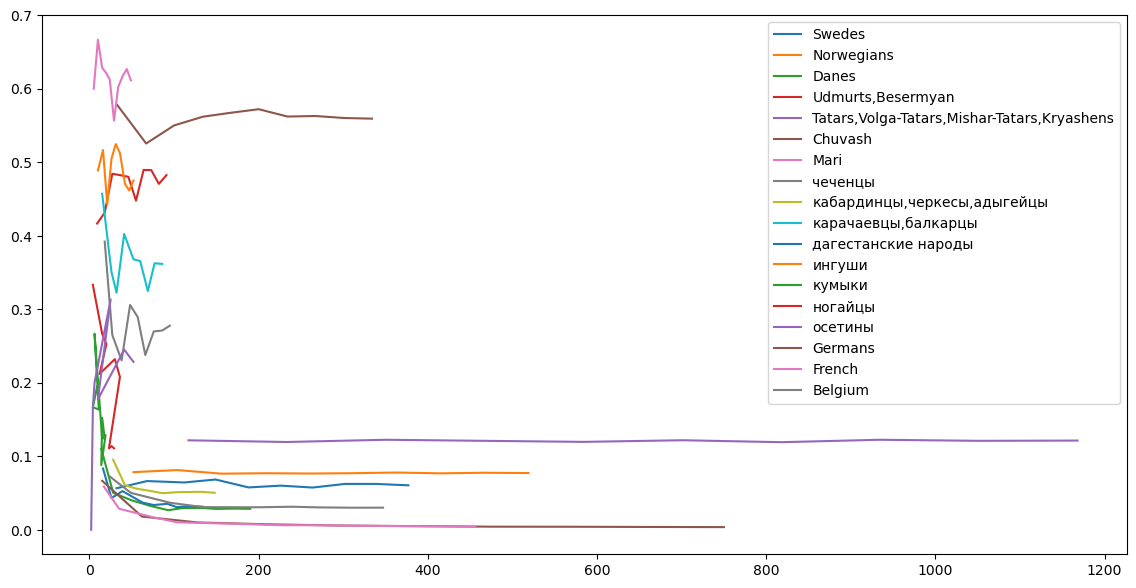

In [29]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,7)

for line in lines:
    if line["label"]!='English':
        plt.plot(line['pop_sizes'], line['edge_probability'] , label=line["label"])
    
plt.legend()